In [52]:
import os
import glob
from pathlib import Path
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Set Up Environment

In [53]:
# Root directory for dataset
DATA_ROOT = Path("/Users/classes/csc334bd/kaggle_data")

# Zip file path
ZIP_PATH = DATA_ROOT / "recodai-luc-scientific-image-forgery-detection.zip"

# Extracted dataset directory
ZIP_DIR = DATA_ROOT / "recodai-luc"

# Dataset subdirectories
TRAIN_IMG_DIR = ZIP_DIR / "train_images/*/"
TRAIN_MASK_DIR = ZIP_DIR / "train_masks/"
TEST_IMG_DIR  = ZIP_DIR / "test_images"

SAMPLE_SUB_PATH = ZIP_DIR / "sample_submission.csv"  # Kaggle provides this

In [54]:
# Extract the data -- I already did this for the class directory, so you don't need to run it unless you're working elsewere
print("ZIP_PATH exists:", ZIP_PATH.exists())
print("ZIP_PATH:", ZIP_PATH)

if not ZIP_DIR.exists():
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(ZIP_DIR)
        
        print("Done extracting!")
else:
    print("Dataset already extracted.")

ZIP_PATH exists: True
ZIP_PATH: /Users/classes/csc334bd/kaggle_data/recodai-luc-scientific-image-forgery-detection.zip
Dataset already extracted.


In [55]:
# Defines training parameters for your UNet model. Controls different aspects of how the model learns.
IMG_SIZE = 96   # sets the image resolution, can bump later
BATCH_SIZE = 4   # number of image–mask pairs per training step, keep small to start
NUM_EPOCHS = 1   # controls how many times the model is passed through the training dataset, short “toy” training; they can increase

In [56]:
train_image_paths = sorted(glob.glob(str(TRAIN_IMG_DIR / "*.png")))
print("Train images found:", len(train_image_paths))

train_mask_paths = sorted(glob.glob(str(TRAIN_MASK_DIR / "*.npy")))
print("Train masks found:", len(train_mask_paths))

Train images found: 5128
Train masks found: 2751


In [57]:
# Initializing a dictionary that's keyed by the ID (mask_001) to find the matching mask for each image
# Part of segmentation
mask_by_id = {
    Path(p).stem: p
    for p in glob.glob(str(TRAIN_MASK_DIR / "*.npy"))
}

list(mask_by_id.items())[:3]

[('37783',
  '/Users/classes/csc334bd/kaggle_data/recodai-luc/train_masks/37783.npy'),
 ('20882',
  '/Users/classes/csc334bd/kaggle_data/recodai-luc/train_masks/20882.npy'),
 ('48997',
  '/Users/classes/csc334bd/kaggle_data/recodai-luc/train_masks/48997.npy')]

In [58]:
# Creates a smaller sample from the images to work with to speed up the demo

# pick a random subset of indices
subset_indices = torch.randperm(len(train_image_paths))[:NUM_TRAIN_SAMPLES]

# wrap in a Subset
train_ds_small = Subset(train_image_paths, subset_indices)
#train_ds_small = Subset(train_ds, subset_indices)


# remake the DataLoader (reuse your old batch_size / num_workers)
train_loader = DataLoader(
    train_ds_small,
    batch_size=BATCH_SIZE,   # put your old batch size here
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

## Supervised Segmentation
Because the masks are based on the pixed, we need to infer “no mask” ⇒ all-zero mask

In [59]:
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch

class ForgeryDataset(Dataset):
    def __init__(self, image_paths, mask_by_id, img_size=256, augment=False):
        self.image_paths = image_paths
        self.mask_by_id = mask_by_id
        self.img_size = img_size
        self.augment = augment

        self.img_transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

        # We'll still use PIL Resize for masks
        self.mask_resize = T.Resize((img_size, img_size), interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        case_id = Path(img_path).stem

        # ---------- IMAGE ----------
        image = Image.open(img_path).convert("RGB")
        image = self.img_transform(image)

        # ---------- MASK ----------
        if case_id in self.mask_by_id:
            npy_path = self.mask_by_id[case_id]
            mask_np = np.load(npy_path)      # e.g. (2, H, W) or (1, 1, 648) etc.

            # Ensure we end up with a 2D array (H, W)
            if mask_np.ndim == 3:
                # Common case: (2, H, W) or (1, H, W)
                if mask_np.shape[0] <= 2:
                    # take first channel as "forgery" mask
                    mask_np = mask_np[0]         # -> (H, W) or (1, W)
                elif mask_np.shape[-1] <= 2:
                    mask_np = mask_np[..., 0]
                else:
                    # fall back: combine channels
                    mask_np = mask_np.max(axis=0)

            # Remove any extra singleton dims, e.g. (1, 648) -> (648,)
            mask_np = np.squeeze(mask_np)

            # If it's 1D at this point, treat as a 1xN mask
            if mask_np.ndim == 1:
                mask_np = mask_np.reshape(1, -1)

            # Binarize and convert to 0–255
            mask_np = (mask_np > 0).astype("uint8") * 255

            # Now PIL is happy: 2D array = grayscale image
            mask_img = Image.fromarray(mask_np)
            mask_img = self.mask_resize(mask_img)
            mask = T.ToTensor()(mask_img)         # (1, H, W)
            mask = (mask > 0.5).float()
        else:
            mask = torch.zeros((1, self.img_size, self.img_size), dtype=torch.float32)

        # ---------- AUGMENTATION ----------
        if self.augment and torch.rand(1) < 0.5:
            image = torch.flip(image, dims=[2])
            mask = torch.flip(mask, dims=[2])

        return image, mask, case_id


In [60]:
# Make sure things look OK, check a random mask image pair

import random

some_case = random.choice(list(mask_by_id.keys()))
m = np.load(mask_by_id[some_case])
print("case_id:", some_case)
print("mask shape:", m.shape, "dtype:", m.dtype)
print("min/max:", m.min(), m.max())


case_id: 28962
mask shape: (1, 666, 1000) dtype: uint8
min/max: 0 1


In [61]:
# simple train/validation split – could also stratify based on "has mask"
n_total = len(train_image_paths) # total number of images in dataset
n_train = int(0.8 * n_total) # ensures only 80% of images will be used for training so 20% can be used for validation

#Initializing dataset objects
train_ds_small = ForgeryDataset(train_image_paths[:n_train], mask_by_id, IMG_SIZE, augment=True) # Training
val_ds   = ForgeryDataset(train_image_paths[n_train:], mask_by_id, IMG_SIZE, augment=False) # Validation

#Initializing data loader objects 
train_loader = DataLoader(train_ds_small, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # Loads data in batches of (BATCH_SIZE)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

len(train_ds_small), len(val_ds) #number of samples in training and validation sets

(4102, 1026)

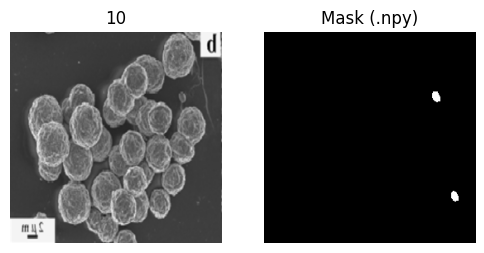

In [62]:
# View the data

img, mask, cid = train_ds[0] #Accesses the first sample (index 0) from training set

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title(cid)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask[0], cmap="gray")
plt.title("Mask (.npy)")
plt.axis("off")
plt.show()

## U-Net Style Model
Let's try a U-Net approach

In [63]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class SmallUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        # ↓↓↓ all channel sizes halved ↓↓↓
        self.down1 = DoubleConv(in_channels, 8)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(8, 16)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(16, 32)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(32, 64)

        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(64, 32)
        self.up2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(32, 16)
        self.up1 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(16, 8)

        self.final = nn.Conv2d(8, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))

        x4 = self.bottleneck(self.pool3(x3))

        # Decoder
        x = self.up3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        logits = self.final(x)   # (B,1,H,W)
        return logits

In [64]:
model = SmallUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [65]:
def iou(preds, targets, thresh=0.5, eps=1e-6):
    """
    preds, targets: (B,1,H,W) tensors with probs / 0-1 masks
    """
    preds_bin = (preds > thresh).float()
    targets_bin = (targets > 0.5).float()

    intersection = (preds_bin * targets_bin).sum(dim=(1,2,3))
    union = (preds_bin + targets_bin - preds_bin * targets_bin).sum(dim=(1,2,3)) + eps
    iou = (intersection + eps) / union
    return iou.mean()

## Do the training

In [66]:
# These parameters will make it go faster, but perform worse than using all the data
MAX_TRAIN_BATCHES = 10   # cap batches per epoch
MAX_VAL_BATCHES   = 10

In [67]:
from tqdm.notebook import tqdm  # works best in Jupyter

def train_one_epoch(model, loader, optimizer, criterion, max_batches=None):
    """
    Train for a single epoch.

    max_batches:
        - None  => use ALL batches in loader
        - int k => use at most k batches (handy for fast debug runs)
    """
    model.train()
    running_loss = 0.0
    running_iou  = 0.0
    total_samples = 0

    num_steps = len(loader) if max_batches is None else min(len(loader), max_batches)

    pbar = tqdm(loader, desc="Train", total=num_steps, leave=True)

    for batch_idx, batch in enumerate(pbar):
        if max_batches is not None and batch_idx >= max_batches:
            break

        images, masks = batch[:2]
        images = images.to(device)
        masks  = masks.to(device)
        bs = images.size(0)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = torch.sigmoid(outputs)
            batch_iou = iou(probs, masks)

        running_loss += loss.item() * bs
        running_iou  += batch_iou * bs
        total_samples += bs

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    if total_samples == 0:
        return 0.0, 0.0

    avg_loss = running_loss / total_samples
    avg_iou  = running_iou / total_samples
    return avg_loss, avg_iou


def eval_one_epoch(model, loader, criterion, max_batches=None):
    """
    Evaluate on a dataset.

    max_batches:
        - None  => use ALL batches in loader (this is what you want for "all 48")
        - int k => use at most k batches (for fast sanity checks)
    """
    model.eval()
    running_loss = 0.0
    running_iou  = 0.0
    total_samples = 0

    num_steps = len(loader) if max_batches is None else min(len(loader), max_batches)

    pbar = tqdm(loader, desc="Val", total=num_steps, leave=False)

    with torch.no_grad():
        for batch_idx, batch in enumerate(pbar):
            if max_batches is not None and batch_idx >= max_batches:
                break

            images, masks = batch[:2]
            images = images.to(device)
            masks  = masks.to(device)
            bs = images.size(0)

            outputs = model(images)
            loss = criterion(outputs, masks)
            probs = torch.sigmoid(outputs)
            batch_iou = iou(probs, masks)

            running_loss += loss.item() * bs
            running_iou  += batch_iou * bs
            total_samples += bs

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    if total_samples == 0:
        return 0.0, 0.0

    avg_loss = running_loss / total_samples
    avg_iou  = running_iou / total_samples
    return avg_loss, avg_iou

In [68]:
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_iou = eval_one_epoch(model, val_loader, criterion)

    print(
        f"Epoch {epoch:02d} "
        f"| train_loss={train_loss:.4f}, train_iou={train_iou:.4f} "
        f"| val_loss={val_loss:.4f}, val_iou={val_iou:.4f}"
    )


Epoch 1/1


Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 01 | train_loss=0.2528, train_iou=0.0046 | val_loss=0.1838, val_iou=0.0019


# RLE
Run-length encoded (RLE) mask to ensure binary output (authentic/forgery)

In [69]:
def mask_to_rle(mask):
    """
    mask: 2D numpy array of 0/1, shape (H,W)
    returns: RLE string like "start length start length ..."
    """
    pixels = mask.flatten(order="F")  # column-major if needed; Kaggle often uses this
    # If competition uses row-major, change to order="C".
    # Check once in a tiny debug notebook on Kaggle.
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] = runs[1::2] - runs[0::2]
    rle = " ".join(str(x) for x in runs)
    return rle


## Make Predictions

In [70]:
class ForgeryTestDataset(Dataset):
    def __init__(self, image_dir, img_size=256):
        self.image_paths = sorted(glob.glob(str(image_dir / "*.png")))
        self.img_size = img_size
        self.img_transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        case_id = Path(img_path).stem
        img = Image.open(img_path).convert("RGB")
        img = self.img_transform(img)
        return img, case_id


### They only gave us one test image, but let's try anyways

In [71]:
from torch.utils.data import DataLoader

# Create test dataset & dataloader from all PNGs in TEST_IMG_DIR
test_ds = ForgeryTestDataset(TEST_IMG_DIR, IMG_SIZE)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

print("Number of test images:", len(test_ds))
print("Example test path:", test_ds.image_paths[0] if len(test_ds) > 0 else "None")


Number of test images: 1
Example test path: /Users/classes/csc334bd/kaggle_data/recodai-luc/test_images/45.png


In [72]:
model.eval()
pred_annotations = []

with torch.no_grad():
    for img, case_id in test_loader:
        img = img.to(device)
        logits = model(img)
        probs = torch.sigmoid(logits)[0, 0].cpu().numpy()

        # Simple threshold
        mask_pred = (probs > 0.5).astype(np.uint8)

        # Heuristic: if almost no positive pixels, treat as authentic
        if mask_pred.sum() < 10:  # students can tweak this
            annotation = "authentic"
        else:
            annotation = mask_to_rle(mask_pred)

        # case_id is a list of strings because batch_size=1 => take [0]
        pred_annotations.append((case_id[0], annotation))

# For the local small dataset, we can just build submission directly:
submission = pd.DataFrame(pred_annotations, columns=["case_id", "annotation"])
submission.head()

,case_id,annotation
0,45,authentic


### Instead, we'll evaluate based on the supplemental data (so you can test on it, but please don't use it to train!)

In [73]:
SUPP_IMG_DIR  = ZIP_DIR/ "supplemental_images"
SUPP_MASK_DIR = ZIP_DIR / "supplemental_masks"

In [74]:
from pathlib import Path
import glob

SUPP_IMG_DIR = ZIP_DIR / "supplemental_images"
SUPP_MASK_DIR = ZIP_DIR / "supplemental_masks"

# All masks and their ids
supp_mask_paths = sorted(glob.glob(str(SUPP_MASK_DIR / "*.npy")))
mask_ids = {Path(p).stem for p in supp_mask_paths}

# All images, but keep only those that have a corresponding mask
all_supp_image_paths = sorted(glob.glob(str(SUPP_IMG_DIR / "*.png")))
supp_image_paths = [p for p in all_supp_image_paths if Path(p).stem in mask_ids]

# Build mask_by_id only for those ids that actually have images
supp_mask_by_id = {
    Path(p).stem: p
    for p in supp_mask_paths
    if Path(p).stem in {Path(ip).stem for ip in supp_image_paths}
}

print("Supplemental images with masks:", len(supp_image_paths))
print("Supplemental masks with images:", len(supp_mask_by_id))


Supplemental images with masks: 48
Supplemental masks with images: 48


In [75]:
def gen_predictions(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, masks, _ in loader:
            images = images.to(device)
            masks = masks.to(device)
            bs = images.size(0)

            logits = model(images)
            loss = criterion(logits, masks)

            probs = torch.sigmoid(logits)
            batch_iou = iou(probs, masks)

            total_loss += loss.item() * bs
            total_iou += batch_iou * bs
            total_samples += bs

    if total_samples == 0:
        return 0.0, 0.0

    avg_loss = total_loss / total_samples
    avg_iou  = total_iou / total_samples
    return avg_loss, avg_iou

In [76]:
supp_mask_paths = sorted(glob.glob(str(SUPP_MASK_DIR / "*.npy")))
mask_ids = {Path(p).stem for p in supp_mask_paths}

all_supp_image_paths = sorted(glob.glob(str(SUPP_IMG_DIR / "*.png")))
supp_image_paths = [p for p in all_supp_image_paths if Path(p).stem in mask_ids]

supp_mask_by_id = {
    Path(p).stem: p
    for p in supp_mask_paths
    if Path(p).stem in {Path(ip).stem for ip in supp_image_paths}
}

supp_ds = ForgeryDataset(
    supp_image_paths,
    supp_mask_by_id,
    img_size=IMG_SIZE,
    augment=False,
)
print("Supplemental dataset size:", len(supp_ds))   # should be 48

supp_loader = DataLoader(
    supp_ds,
    batch_size=10,   # totally OK
    shuffle=False,
    num_workers=2,
)

Supplemental dataset size: 48


In [77]:
# After loading/creating your model (trained elsewhere or earlier in the notebook):

supp_loss, supp_iou = eval_one_epoch(
    model,
    supp_loader,
    criterion,
    max_batches=None  # or just omit; None is the default
)
print(f"Supplemental set: loss={supp_loss:.4f}, IoU={supp_iou:.4f}")

Val:   0%|          | 0/5 [00:00<?, ?it/s]

Supplemental set: loss=0.3471, IoU=0.0000


In [78]:
submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
submission_path

'submission.csv'